<a href="https://colab.research.google.com/github/Frexander/Final_Portfolio/blob/master/DQN_2_lay_targetN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necesarry packages
!pip install gymnasium
!pip install numpy
!pip install matplotlib
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 8.3 MB/s eta 0:00:00


In [ ]:
# IMport necesarry libraries
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random

In [ ]:
# ALTERNATIVE 1
# Create a nerual network with two layers with 64 neurons, using ReLu as activation function
# Input to layer 1 is all states, output is 64 values
# Input to layer 2 is 64 values, output is action (1 of six)
class QNetwork(nn.Module):
  def __init__(self, input_size, output_size):
    super(QNetwork, self).__init__()
    self.layer1 = nn.Linear(input_size, 64)
    self.layer2 = nn.Linear(64, output_size)
    self.relu = nn.ReLU()

# Define forward pass from layer 1 to layer 2 using relu as activation function
# in layer 1
# return q values for all possible actions in the state
  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.layer2(x)
    return x

In [ ]:
# ALTERNATIVE 2
# Create a nerual network with two layers with 128 neurons, using ReLu as activation function
# Input to layer 1 is all states, output is 128 values
# Input to layer 2 is 64 values, output is action (1 of six)
class QNetwork(nn.Module):
  def __init__(self, input_size, output_size):
    super(QNetwork, self).__init__()
    self.layer1 = nn.Linear(input_size, 128)
    self.layer2 = nn.Linear(128, output_size)
    self.relu = nn.ReLU()

# Define forward pass from layer 1 to layer 2 using relu as activation function
# in layer 1
# return q values for all possible actions in the state
  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.layer2(x)
    return x

In [ ]:
# Create Taxi-v3 encironment
env = gym.make("Taxi-v3")

# Inititalise state- and action-space
state_size = env.observation_space.n
action_size = env.action_space.n

In [ ]:
# Create policy network and target network
policy_network = QNetwork(state_size, action_size)
target_network = QNetwork(state_size, action_size)

# Set target network weights equal to policy network weights
target_network.load_state_dict(policy_network.state_dict())

# Create optimizer to update network weights with learning rate being 0.001
# and loss function being mean squared error
optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
# Alternative A
# Defining training parameters
episodes = 1000
max_steps = 100
epsilon = 1.0           # Staring explore rate
epsilon_min = 0.01      # Minimum explore rate
epsilon_decay = 0.995   # Reduction rate for explore rate
discount_rate = 0.95    # Discount of future reward
target_update = 10      # Update target network every 10 episodes

# Storing rewards for later vizualisation and average revard for every 25th episode
training_rewards = []
average_rewards = []

In [ ]:
# Alternative B
# Defining training parameters
episodes = 1000
max_steps = 100
epsilon = 1.0           # Staring explore rate
epsilon_min = 0.01      # Minimum explore rate
epsilon_decay = 0.997   # Slower reduction rate for explore rate
discount_rate = 0.95    # Discount of future reward
target_update = 20      # Update target network every 20 episodes to try to stabilise learning

# Storing rewards for later vizualisation and average revard for every 25th episode
training_rewards = []
average_rewards = []

In [ ]:
# The network takes state as input, and this state needs to be expressed as a tensor
def state_to_tensor(state):
  state_tensor = torch.zeros(state_size)  # Create tensor with all values set to zero
  state_tensor[state] = 1                 # Set value in for index in tensor corresponding to state to 1
  return state_tensor

In [ ]:
# Training loop
for episode in range(episodes):
  state, infor = env.reset()
  total_rewards = 0

  for step in range(max_steps):
    current_state = state_to_tensor(state)

    if random.random() < epsilon:
      action = env.action_space.sample()  # Choose random action if chosen number is less than epsilon value (explore)
    else:
      with torch.no_grad():
        action = torch.argmax(policy_network(current_state)).item()  # Choose action with highest Q-value (exploit)

    next_state, reward, terminated, truncated, info = env.step(action)  # Perform action and observe result
    total_rewards += reward     # Update total reward based on reward for last action
    next_state_tensor = state_to_tensor(next_state) # Convert next state to tensor

    with torch.no_grad():        # Calculate q-value for target network, only current reward if this is last state in episode
      next_q_values = target_network(next_state_tensor)
      max_next_q = torch.max(next_q_values)
      target_q = reward + discount_rate * max_next_q * (not terminated)

    current_q = policy_network(current_state)[action]  # Calculate current Q-value

    loss = criterion(current_q, target_q)   # Update network based on calculated loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    state = next_state    # Move to next state

    if terminated or truncated:
      break

  epsilon = max(epsilon_min, epsilon * epsilon_decay)
  training_rewards.append(total_rewards)
  average_rewards.append(np.mean(training_rewards[-25:]))

  if episode % target_update == 0:
    target_network.load_state_dict(policy_network.state_dict())

  if episode % 100 == 0:
    print(f"Episode: {episode}")
    print(f"Total Reward: {total_rewards}")
    print(f"Epsilon: {epsilon:.3f}")

Episode: 0
Total Reward: -442
Epsilon: 0.997
Episode: 100
Total Reward: -361
Epsilon: 0.738
Episode: 200
Total Reward: -226
Epsilon: 0.547
Episode: 300
Total Reward: -190
Epsilon: 0.405
Episode: 400
Total Reward: -172
Epsilon: 0.300
Episode: 500
Total Reward: -172
Epsilon: 0.222
Episode: 600
Total Reward: -136
Epsilon: 0.164
Episode: 700
Total Reward: -136
Epsilon: 0.122
Episode: 800
Total Reward: -136
Epsilon: 0.090
Episode: 900
Total Reward: -118
Epsilon: 0.067


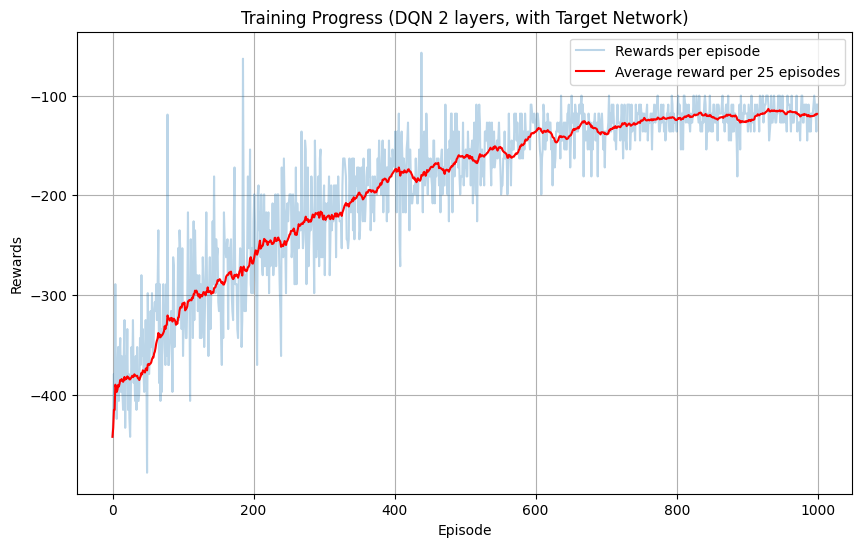

In [ ]:
# Plot results
plt.figure(figsize=(10,6))
plt.plot(training_rewards, label='Rewards per episode', alpha=0.3)
plt.plot(average_rewards, label='Average reward per 25 episodes', color='red')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Training Progress (DQN 2 layers, with Target Network)')
plt.legend()
plt.grid(True)
plt.show()